In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, \
recall_score, precision_score, accuracy_score, plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

import os
import tempfile

In [2]:
df=pd.read_csv("./datasets/final_data.csv",index_col=0)

In [3]:
X=df[['total_drug_cost', 'total_claim_count', 'total_day_supply',
       'Opioid Claim Count', 'Opioid Prescribing Rate',
       'Long-Acting Opioid Claim Count', 'Long-Acting Opioid Prescribing Rate',
       'Total_Payment_Sum', 'Number of Suppliers',
       'Number of Supplier Beneficiaries', 'Number of Supplier Claims',
       'Average Supplier Submitted Charge',
       'Average Supplier Medicare Allow Amount',
       'Average Supplier Medicare Payment Amount',
       'Average Supplier Medicare Standard Amount', 'is_fraud']]

In [4]:
# Use a utility from sklearn to split and shuffle our dataset.
X_train, X_test = train_test_split(X, test_size=0.25)
X_train, X_val = train_test_split(X_train, test_size=0.25)

In [5]:
# Form np arrays of labels and features.
train_labels = np.array(X_train.pop('is_fraud'))
bool_train_labels = train_labels != 0
val_labels = np.array(X_val.pop('is_fraud'))
test_labels = np.array(X_test.pop('is_fraud'))


In [6]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [7]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)

X_val = ss.transform(X_val)
X_test = ss.transform(X_test)



In [8]:
X_train = np.clip(X_train, -5, 5)
X_val = np.clip(X_val, -5, 5)
X_test = np.clip(X_test, -5, 5)

In [9]:
X_train.shape,X_test.shape,X_val.shape

((100174, 15), (44523, 15), (33392, 15))

In [10]:
train_labels.shape,val_labels.shape,test_labels.shape

((100174,), (33392,), (44523,))

In [11]:
neg, pos = np.bincount(df['is_fraud'])

In [12]:
neg, pos

(177973, 116)

In [13]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
            keras.layers.Dense(16, activation='relu',
            input_shape=(X_train.shape[-1],)),
            keras.layers.Dropout(0.5),
               keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
         metrics=metrics)

    return model

In [14]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [15]:
model=make_model()


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                256       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


Resampling

In [17]:
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [18]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(100114, 15)

In [19]:
X_res = np.concatenate([res_pos_features, neg_features], axis=0)
label_res = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(label_res))
np.random.shuffle(order)
X_res = X_res[order]
label_res = label_res[order]

X_res.shape

(200228, 15)

In [20]:
BUFFER_SIZE = 100000
def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [21]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [-0.47524078 -0.32678388 -0.47087588 -0.42206689 -0.5168054  -0.22126438
 -0.48089463 -0.08229784 -0.10004723 -0.09340877 -0.21185872 -0.42155817
 -0.35711146 -0.34928098 -0.35103402]

Label:  1


In [22]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [23]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.50732421875


In [24]:
resampled_steps_per_epoch = np.ceil(2.0*(neg)/BATCH_SIZE)
resampled_steps_per_epoch

174.0

In [25]:
resampled_model = make_model()
# resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_val, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100
174/174 [==============================] - 3s 20ms/step - loss: 0.7240 - tp: 106608.0000 - fp: 91110.0000 - tn: 87295.0000 - fn: 71339.0000 - accuracy: 0.5441 - precision: 0.5392 - recall: 0.5991 - auc: 0.5587 - val_loss: 0.6538 - val_tp: 12.0000 - val_fp: 15677.0000 - val_tn: 17692.0000 - val_fn: 11.0000 - val_accuracy: 0.5302 - val_precision: 7.6487e-04 - val_recall: 0.5217 - val_auc: 0.5710
Epoch 2/100
174/174 [==============================] - 3s 17ms/step - loss: 0.6616 - tp: 122437.0000 - fp: 83964.0000 - tn: 93777.0000 - fn: 56174.0000 - accuracy: 0.6067 - precision: 0.5932 - recall: 0.6855 - auc: 0.6510 - val_loss: 0.6379 - val_tp: 13.0000 - val_fp: 14821.0000 - val_tn: 18548.0000 - val_fn: 10.0000 - val_accuracy: 0.5559 - val_precision: 8.7637e-04 - val_recall: 0.5652 - val_auc: 0.6116
Epoch 3/100
174/174 [==============================] - 3s 17ms/step - loss: 0.6378 - tp: 122937.0000 - fp: 76334.0000 - tn: 102223.0000 - fn: 54858.0000 - accuracy: 0.6318 - precisio

In [26]:
train_pred = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_pred = resampled_model.predict(X_test, batch_size=BATCH_SIZE)

In [27]:
resampled_results = resampled_model.evaluate(X_test, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

loss :  0.5921505093574524
tp :  18.0
fp :  16844.0
tn :  27646.0
fn :  15.0
accuracy :  0.6213417649269104
precision :  0.001067489036358893
recall :  0.5454545617103577
auc :  0.650733232498169



In [32]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate medicare provider Detected (True Negatives): ', cm[0][0])
    print('Legitimate medicare provider Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent medicare provider Missed (False Negatives): ', cm[1][0])
    print('Fraudulent medicare provider Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent provider: ', np.sum(cm[1]))

Legitimate medicare provider Detected (True Negatives):  27646
Legitimate medicare provider Incorrectly Detected (False Positives):  16844
Fraudulent medicare provider Missed (False Negatives):  15
Fraudulent medicare provider Detected (True Positives):  18
Total Fraudulent provider:  33


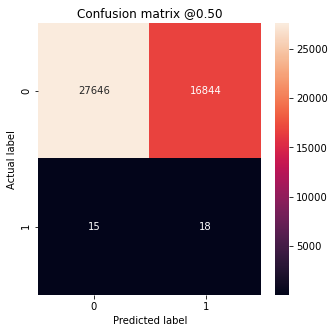

In [34]:
plot_cm(test_labels, test_pred)

credit : https://www.tensorflow.org/tutorials/structured_data/imbalanced_data